1. 准备训练数据数据

shape of s: (10000, 2)


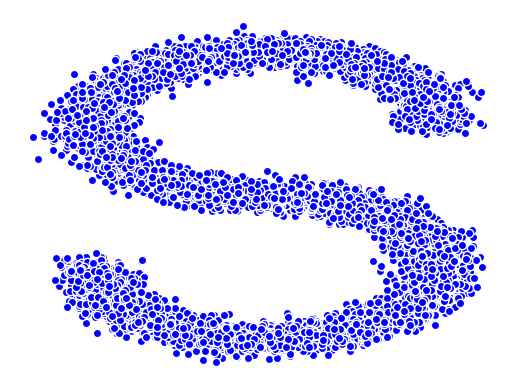

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
from tqdm import tqdm
import gc

s_curve,_ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0

print("shape of s:", np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='blue', edgecolor='white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

2、确定超参数的值

\begin{equation}\\
\alpha_t = 1 - \beta_t
\end{equation}

\begin{equation}\\
\beta_t = 1 - \alpha_t
\end{equation}

\begin{equation}\\
\bar{\alpha_k}=\prod_{i=1}^{k}{\alpha_i}
\end{equation}

In [2]:
num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)

alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)

alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [3]:
use_cpu = True

if not use_cpu and torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

3、确定扩散过程任意时刻的采样值

\begin{equation}\\
x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon_0
\end{equation}

其中，

1. $\alpha_0, \alpha_1, ..., \alpha_t$为手工定义的超参数；
2. $\bar{\alpha_k}=\prod_{i=1}^{k}{\alpha_i}$；
3. $\epsilon_0\: \sim \:N(\epsilon;0, I)$；
4. $x_0$为输入；
5. $t$为step；

In [4]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_xt_given_x0(x_0, t):
    """
    可以基于x[0]得到任意时刻t的x[t]
    """
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声

4、演示原始数据分布加噪100步后的结果

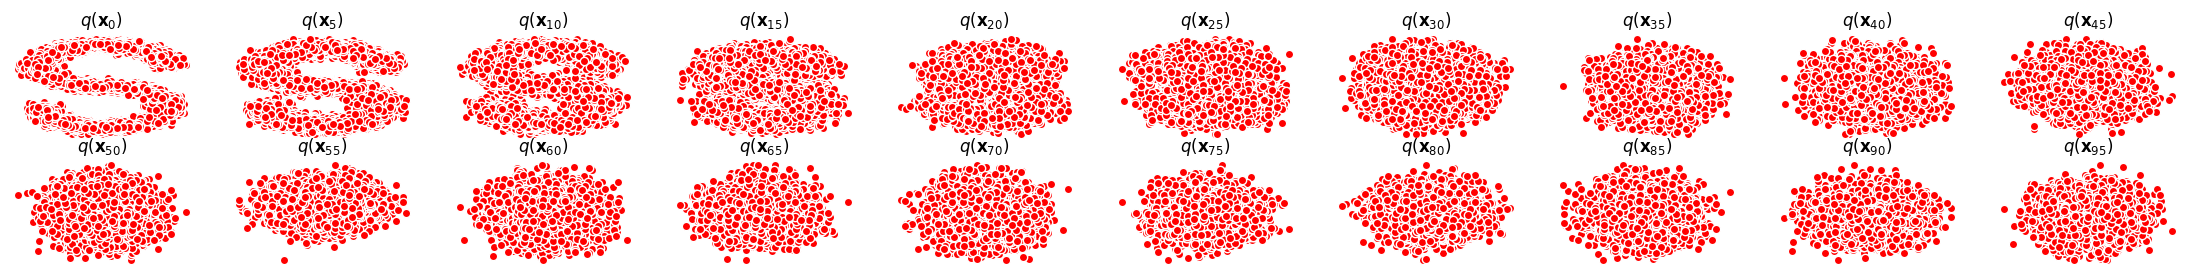

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='black')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_xt_given_x0(dataset, torch.tensor([i * num_steps // num_shows]))#生成t时刻的采样数据
    axs[j,k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{' + str(i * num_steps // num_shows) + '})$')

5、编写拟合逆扩散过程高斯分布的模型

In [6]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
    def forward(self, x, t):
        """
        Inputs:
            x: (b, 2)
            t: list of int
        """
        x = x.to(device)
        t = t.to(device)
        for idx, embedding_layer in enumerate(self.step_embeddings):
            x = self.linears[2*idx](x)  # (b, num_units)
            t_embedding = embedding_layer(t)  # (b, num_units)
            x += t_embedding  # (b, num_units)
            x = self.linears[2*idx+1](x)  # (b, num_units)
            
        x = self.linears[-1](x)  # (b, 2)
        
        return x

6、编写训练的误差函数

\begin{equation}\\
x_t = \sqrt{\bar{\alpha_t}} + \sqrt{1 - \bar{\alpha_t}}\cdot\epsilon_0 \\
\end{equation}


其中，

1. $\alpha_0, \alpha_1, ..., \alpha_t$为手工定义的超参数；
2. $\bar{\alpha_k}=\prod_{i=1}^{k}{\alpha_i}$；
3. $\epsilon_0\: \sim \:N(\epsilon;0, I)$；
4. $x_0$为输入；
5. $t$为step；

损失函数：

\begin{equation}\\
\underset{\theta}{\arg\min}\quad D_{KL}\left( N \left( q\left( x_{t-1}|x_t, x_0 \right) \right)\: \Vert \: p_{\theta}\left(x_{t-1}|x_t\right) \right)= \underset{\theta}{\arg\min}\quad \frac{1}{2\sigma^2_q(t)}\frac{(1-\alpha_t)^2}{(1-\bar{\alpha_t})\alpha_t}\left[||\epsilon_0 - \hat{\epsilon_{\theta}}(x_t, t)||^2_2\right]
\end{equation}

即，

\begin{equation}\epsilon_{\theta}(x_t, t)\rightarrow \epsilon_0 \end{equation}

其中target为 $\epsilon_0$:

\begin{equation}\epsilon_0\: \sim \:N(\epsilon;0, I) \end{equation}


In [7]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """
    对任意时刻t进行采样计算loss
    """
    
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音epsilon_0
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x_t = x_0 * a + e * aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x_t, t.squeeze(-1))  # 
    
    #与真实噪声一起计算误差，求平均值
    return (e.to(device) - output).square().mean()

7、编写逆扩散采样函数（inference）

\begin{equation}\mu_{\theta}\left(x_t, t\right) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\hat\epsilon_{\theta}\left(x_t, t\right)\right)\end{equation}

其中，

1. $\mu_{\theta}$是网络的预测输出；
2. $x_t$是经由$x_0$加入$t$步噪声后的图像；
3. $\alpha_t$是超参数；
4. $\bar{\alpha_t}$是由$\alpha_0, \alpha_1, ..., \alpha_n$计算得到；

encoder过程（加噪过程），第$i$个step加入的噪声$\epsilon_i$是从$N\left(\alpha_i, \left(1-\alpha_i\right)\right)$的分布中采集的

diffusion model的优化过程等价于下面公式：

\begin{equation}\\
\underset{\theta}{\arg\min}\quad D_{KL}\left( N \left( q\left( x_{t-1}|x_t, x_0 \right) \right)\: \Vert \: p_{\theta}\left(x_{t-1}|x_t\right) \right)=
\underset{\theta}{\arg\min}\quad D_{KL}\left(N\left(x_{t-1}; \mu_q, \sum_q(t)\right)\:\Vert\: N\left(x_{t-1}; \mu_{\theta}, \sum_q(t)\right)\right)\\
\end{equation}

其中，$\mu_{\theta}$是由网络通过学习得到，其代表的含义是：$x_t$是通过在原始输入$x_0$加噪声得到的，加入的噪声是从某个高斯分布中采样的，该高斯分布的均值为$\mu_{\theta}$方差为$\sum_q(t)$；

```
Unlike a Markovian HVAE, the structure of the encoder at each timestep t is not learned; it is fixed as a linear Gaussian model, where the mean and standard deviation can be set beforehand as hyperparameters.
```

\begin{equation} \\
q\left(x_t|x_{t-1}, x_0\right) = q\left(x_t|x_{t-1}\right) = N\left(x_t;\sqrt{\alpha_t} x_{t-1} , \left(1-\alpha_t\right) I\right) \\
\end{equation}

由上式可知：
\begin{equation}\\
\sum_q(t) = \left(1-\alpha_t\right) I
\end{equation}

故，已知$x_{t}$时采样$x_{t-1}$的高斯分布为：

\begin{equation}\\
N\left(x_{t-1}; \mu_q, \sum_q(t)\right)\:\approx \: N\left(x_{t-1}; \mu_{\theta}, \sum_q(t)\right) \: = \: N\left(x_{t-1}; \mu_{\theta}, \left(1-\alpha_t\right) I\right)
\end{equation}


已知$x_{t-1}$是由分布$N\left(x_{t-1}; \mu_{\theta}, \left(1-\alpha_t\right) I\right)$采样得到的，故$x_{t-1}$可按下式计算：

\begin{equation}\\
x_{t-1} = \mu_{\theta} + N(0, I) \cdot \sqrt{1-\alpha_t}
\end{equation}

In [8]:
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """
    从x[T]采样t时刻的重构值
    """
    
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x, t).detach().cpu().numpy()
    
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))  # mu_theta
    
    z = torch.randn_like(x)  # sample from standard norm distribution
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z  # get x_t-1
    
    return (sample)


def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """
    从x[T]恢复x[T-1]、x[T-2]|...x[0]
    """
    
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
        
    return x_seq

8、开始训练模型，打印loss及中间重构效果

Training model...


loss: 0.57241:   0%|          | 0/4000 [00:00<?, ?it/s]

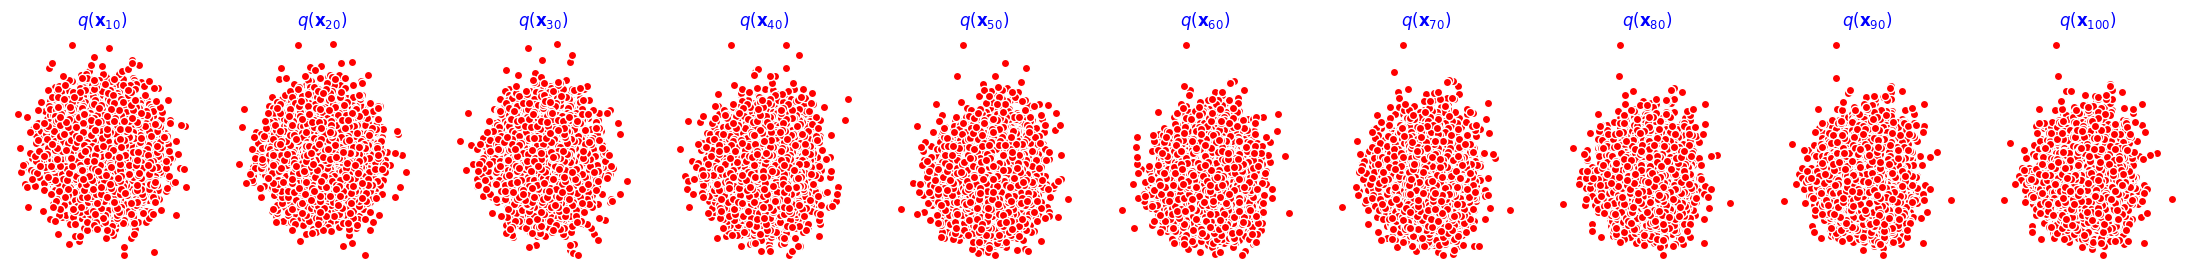

loss: 0.39617:   5%|▌         | 200/4000 [01:04<20:45,  3.05it/s]

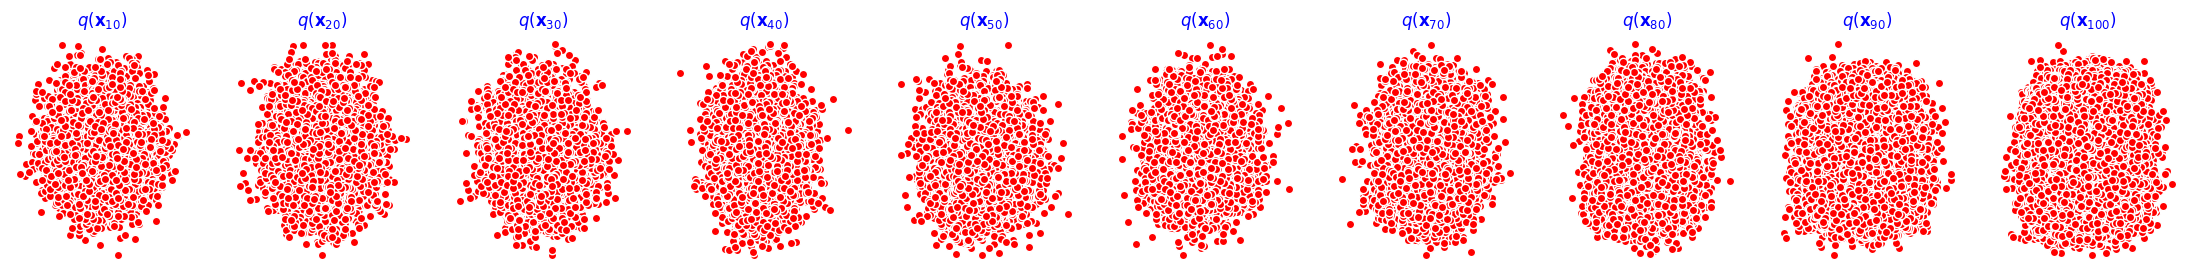

loss: 0.19679:  10%|█         | 400/4000 [02:12<20:40,  2.90it/s]

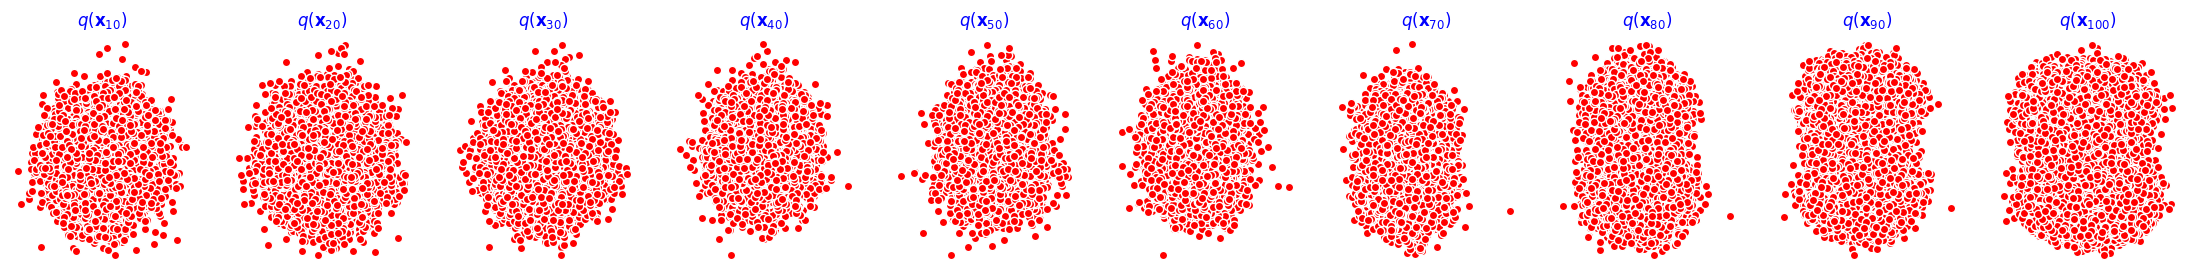

loss: 0.25755:  15%|█▌        | 600/4000 [03:21<18:44,  3.02it/s]

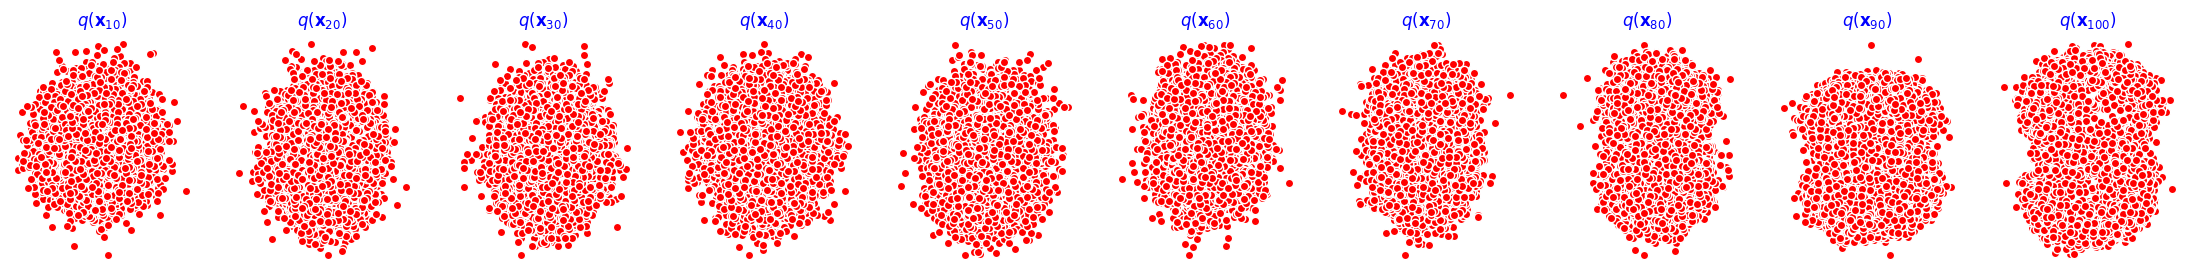

loss: 0.35929:  20%|██        | 800/4000 [04:31<17:35,  3.03it/s]

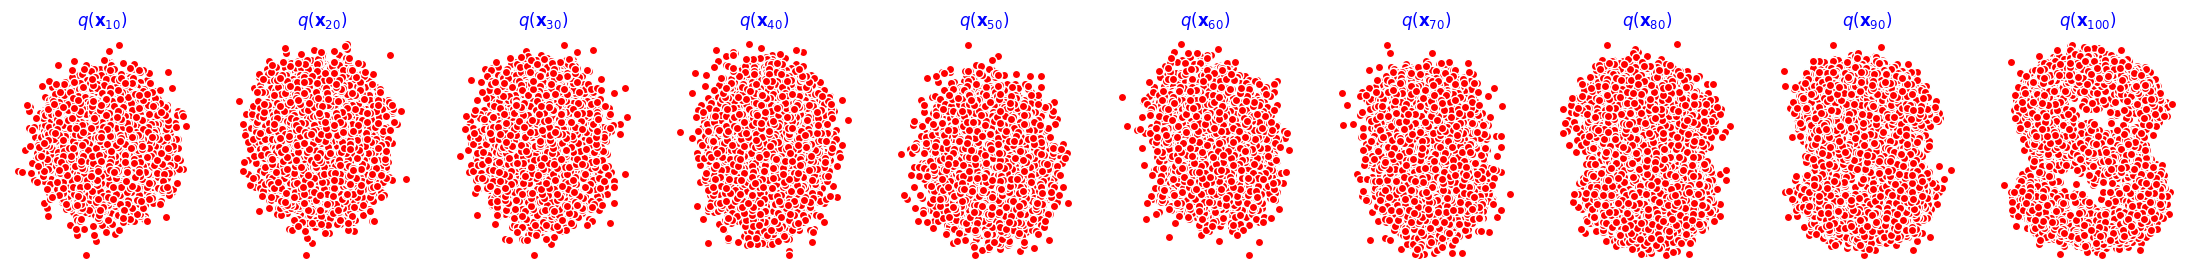

loss: 0.47002:  25%|██▌       | 1000/4000 [05:42<16:54,  2.96it/s]

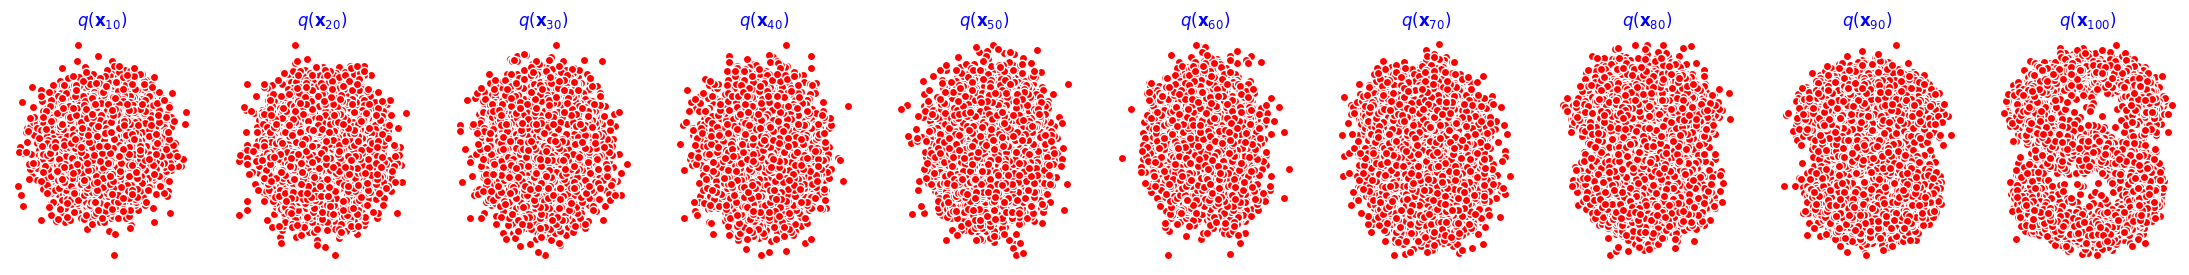

loss: 0.21214:  30%|███       | 1200/4000 [06:55<16:27,  2.83it/s]

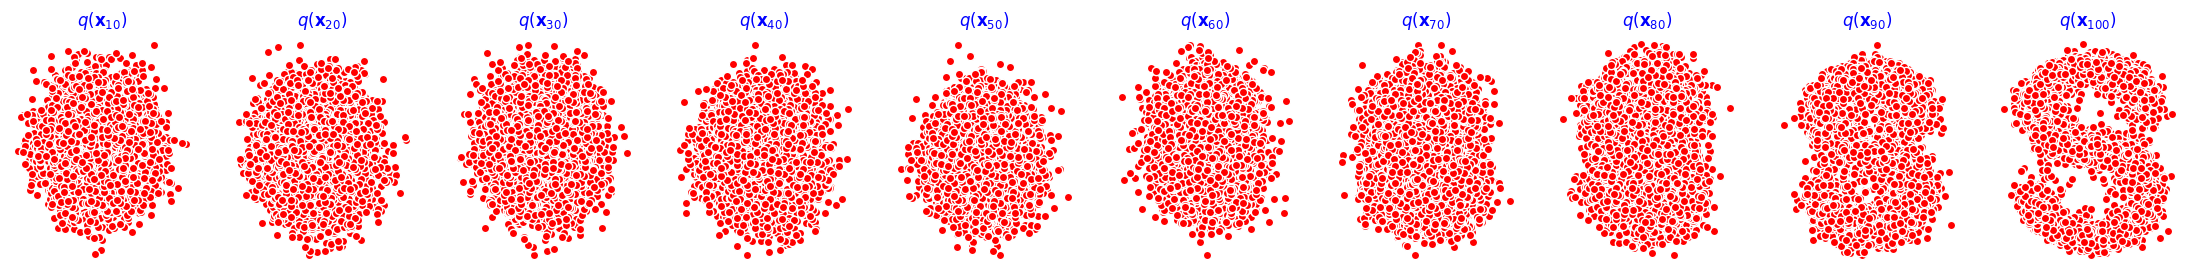

loss: 0.23830:  35%|███▌      | 1400/4000 [08:08<15:30,  2.79it/s]

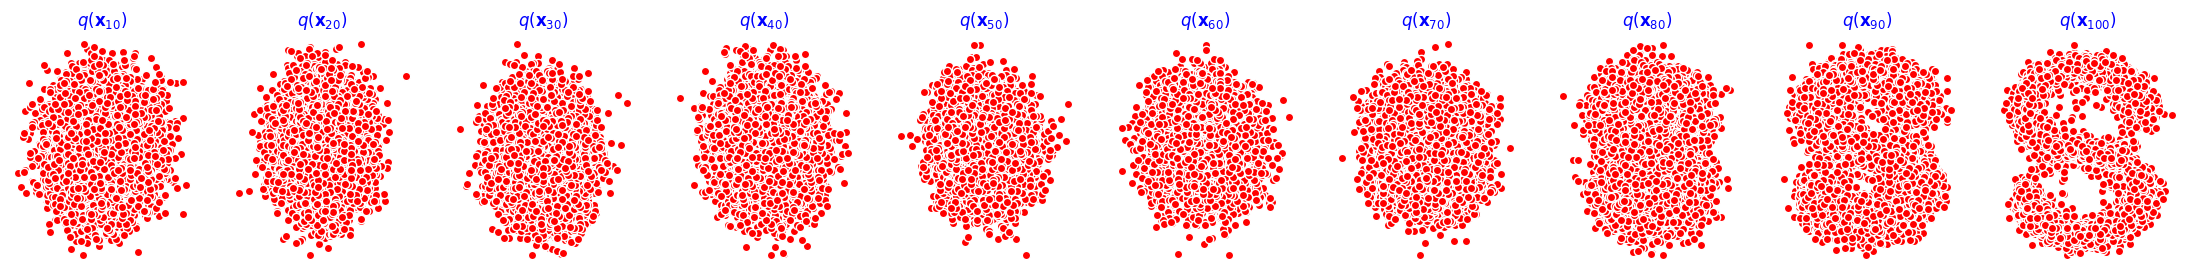

loss: 0.23069:  40%|████      | 1600/4000 [09:22<14:45,  2.71it/s]

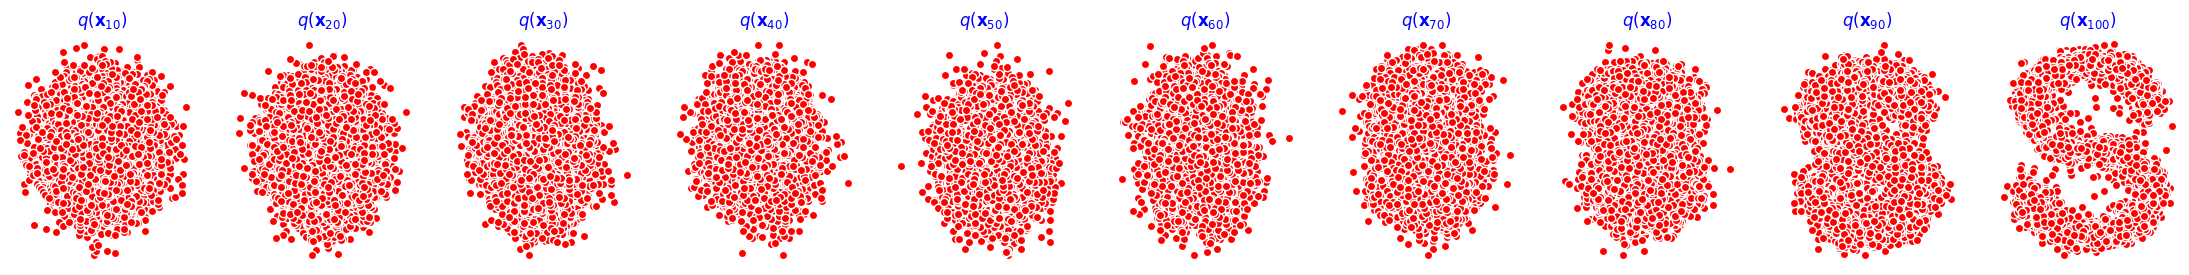

loss: 0.51774:  45%|████▌     | 1800/4000 [10:36<12:52,  2.85it/s]

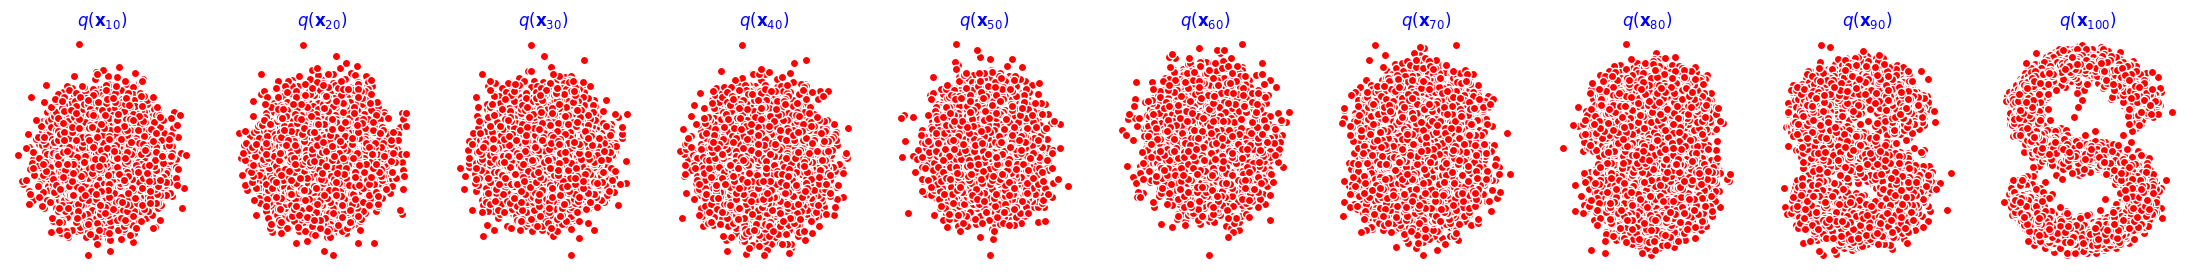

loss: 0.24871:  50%|█████     | 2000/4000 [11:52<12:15,  2.72it/s]

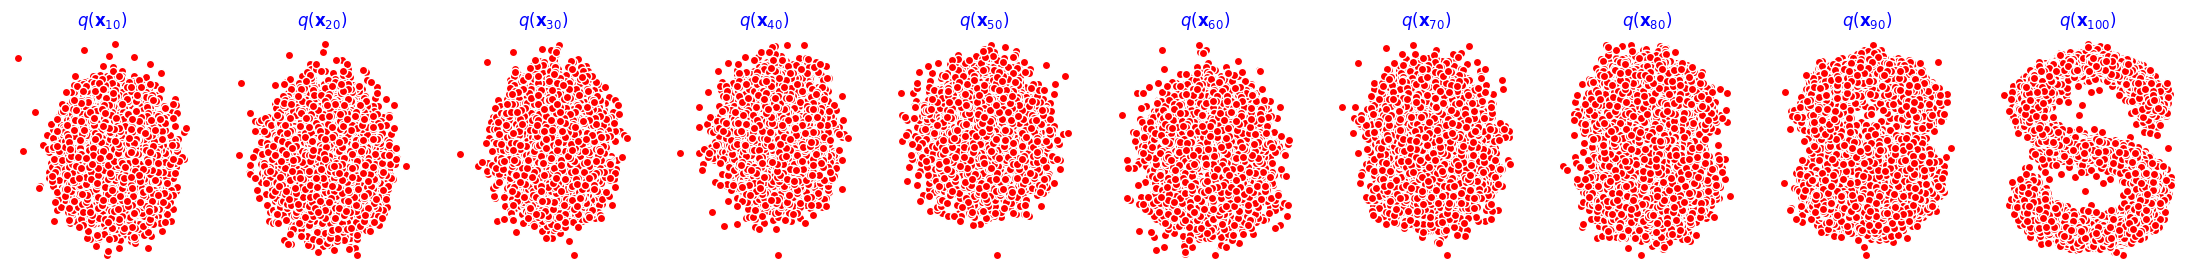

loss: 0.19015:  55%|█████▌    | 2200/4000 [13:09<11:30,  2.61it/s]

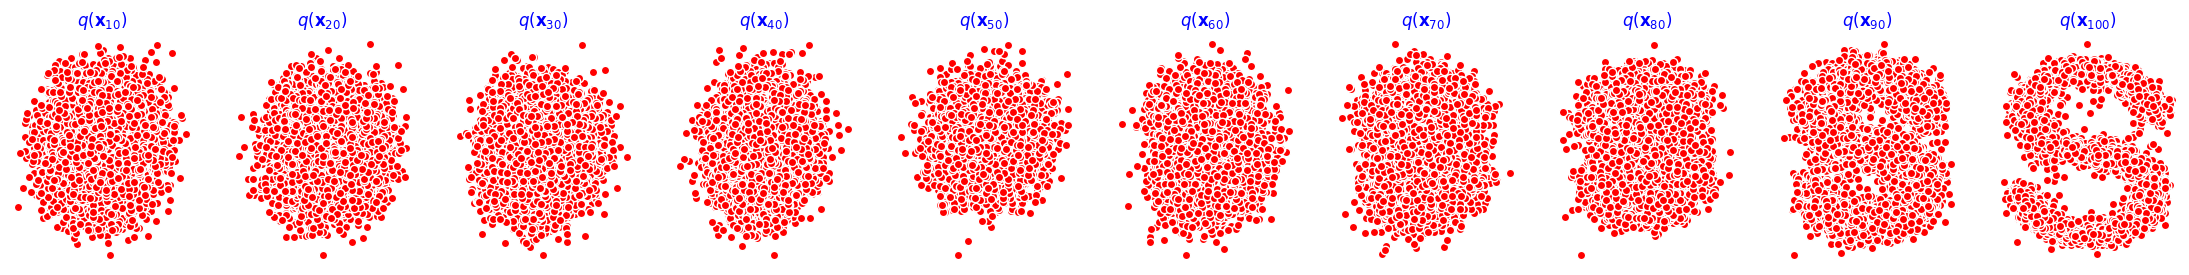

loss: 0.42539:  60%|██████    | 2400/4000 [14:26<09:39,  2.76it/s]

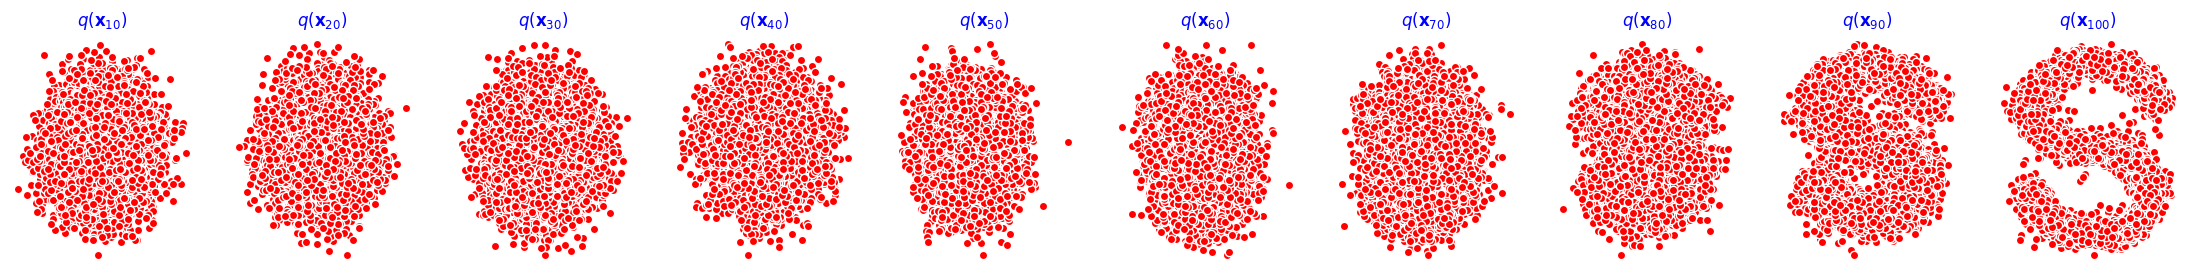

loss: 0.43559:  65%|██████▌   | 2600/4000 [15:42<08:26,  2.76it/s]

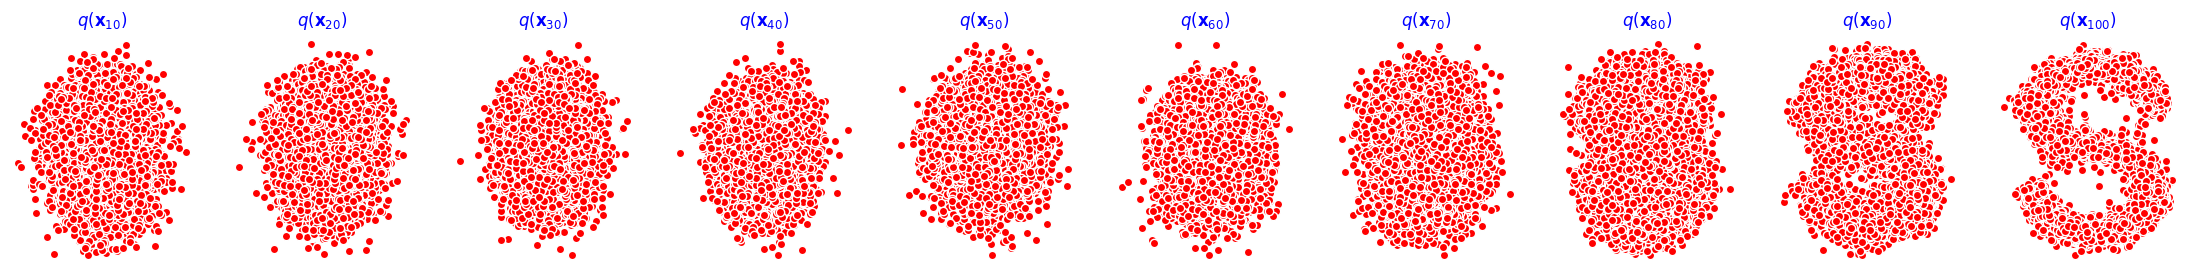

loss: 0.16405:  70%|███████   | 2800/4000 [16:58<07:27,  2.68it/s]

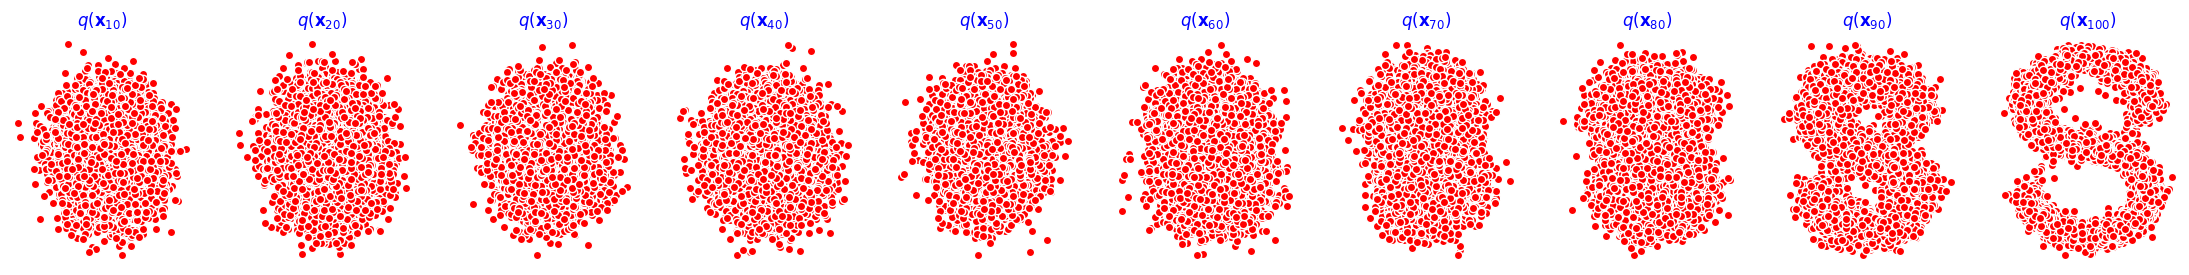

loss: 0.27322:  75%|███████▌  | 3000/4000 [18:14<06:08,  2.71it/s]

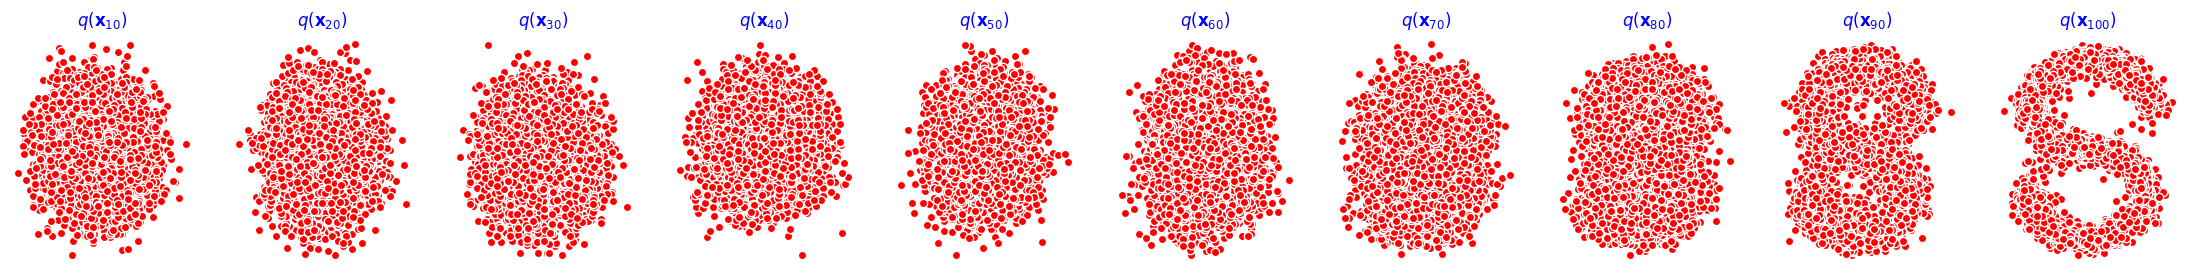

loss: 0.19285:  80%|████████  | 3200/4000 [19:30<04:54,  2.71it/s]

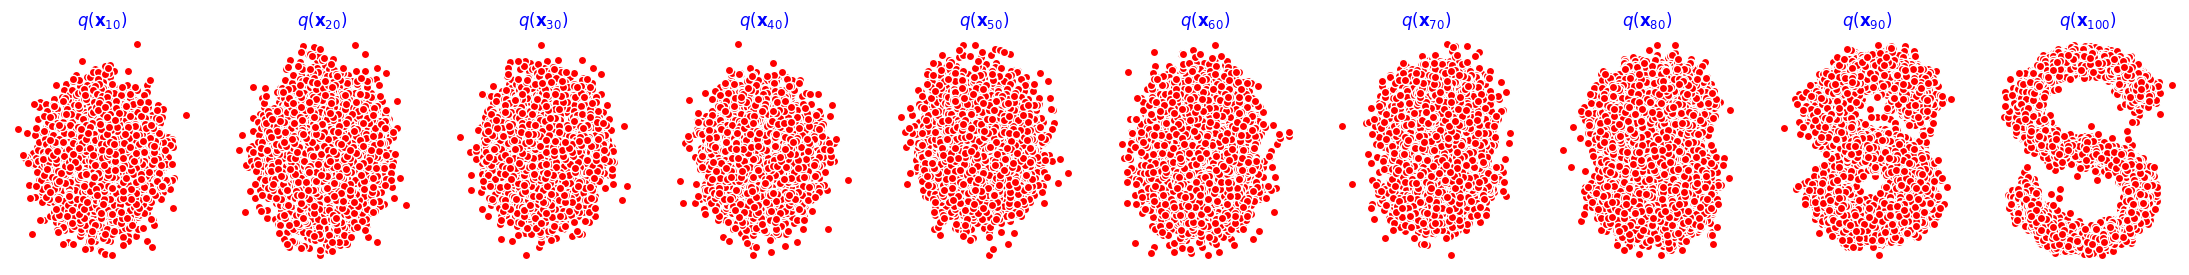

loss: 0.19187:  85%|████████▌ | 3400/4000 [20:46<03:36,  2.77it/s]

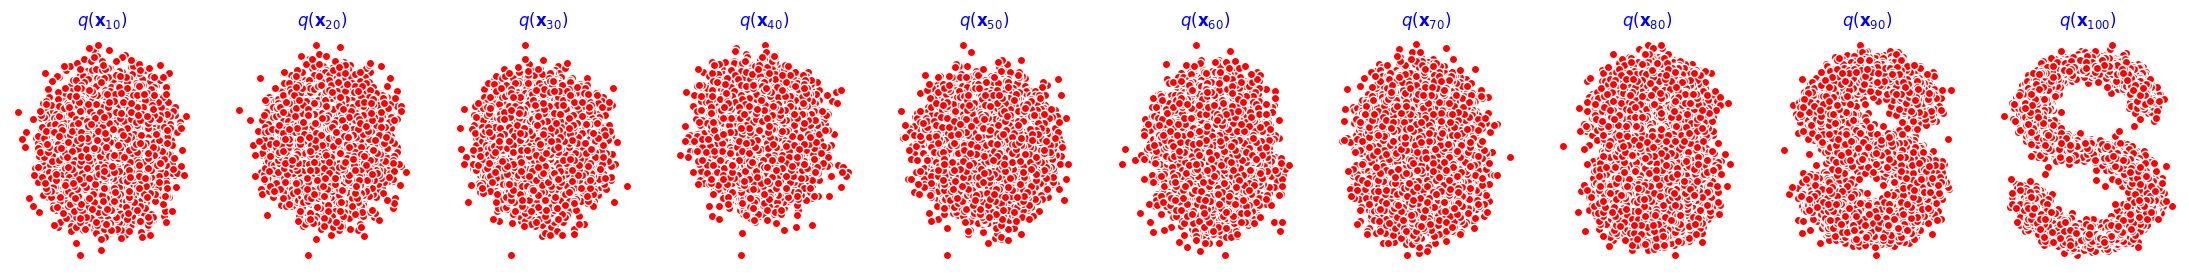

loss: 0.31828:  90%|█████████ | 3600/4000 [22:02<02:37,  2.54it/s]

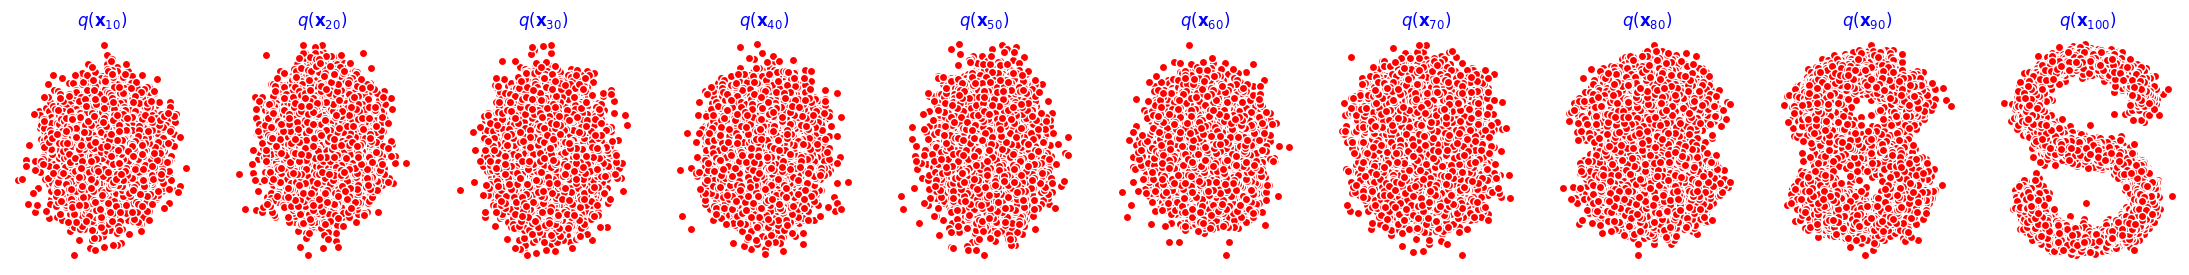

loss: 0.29689:  95%|█████████▌| 3800/4000 [23:19<01:13,  2.72it/s]

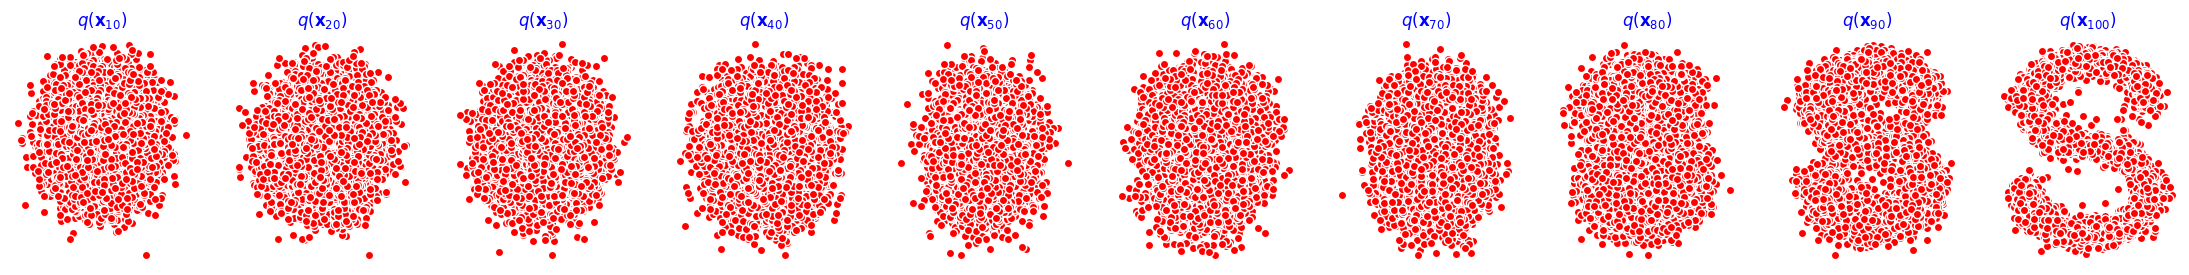

loss: 0.28233: 100%|██████████| 4000/4000 [24:35<00:00,  2.71it/s]


In [9]:
seed = 1234
 
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps).to(device)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_ls = []
with tqdm(total=num_epoch) as tbar:
    for t in range(num_epoch):
        # training
        for idx, batch_x in enumerate(dataloader):
            loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
            loss_ls.append(loss.detach().item())
            
        if t % 5 == 0:
            tbar.set_description(f"loss: {loss.detach().item():.5f}")

        # validation
        if(t % 200 == 0):
            x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
            fig, axs = plt.subplots(1, 10, figsize=(28,3))
            for i in range(1, 11):
                cur_x = x_seq[i*10].detach().cpu().numpy()
                axs[i-1].scatter(cur_x[:,0], cur_x[:,1], color='red', edgecolor='white')
                axs[i-1].set_axis_off()
                axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
            plt.show()
            fig.clear()
            plt.close()
            del fig, axs
            gc.collect()
        
        tbar.update()
    tbar.close()

9、展示训练loss曲线

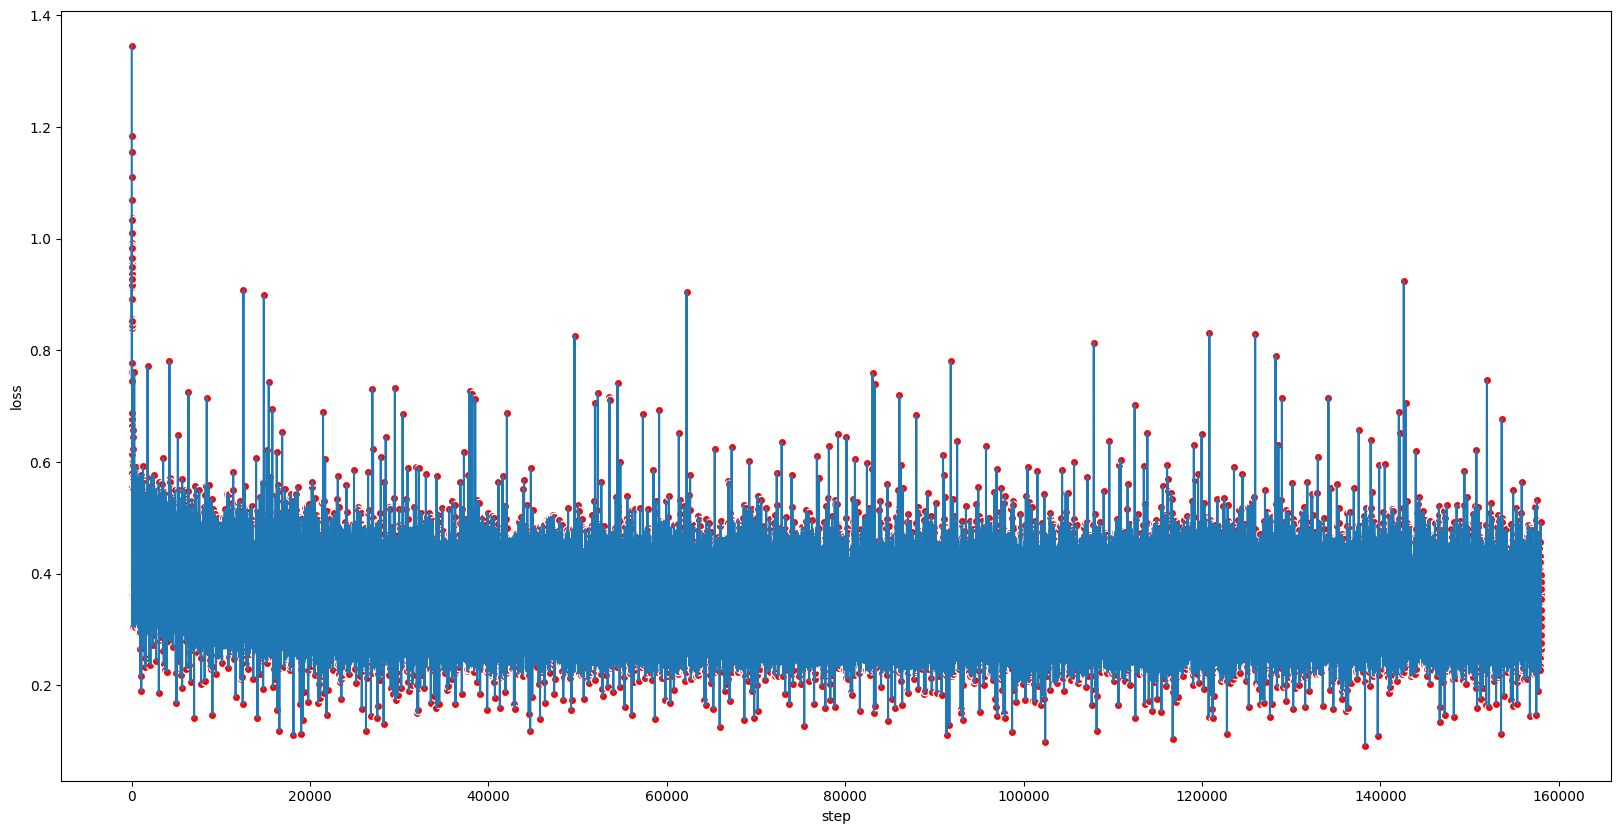

In [17]:
fig, ax = plt.subplots(figsize=[20, 10])

ax.scatter(np.arange(len(loss_ls[::2])), loss_ls[::2], color='red',edgecolor='white')
ax.plot(np.arange(len(loss_ls[::2])), loss_ls[::2])
ax.set_xlabel('step')
ax.set_ylabel('loss')
plt.show()

10、动画演示扩散过程和逆扩散过程

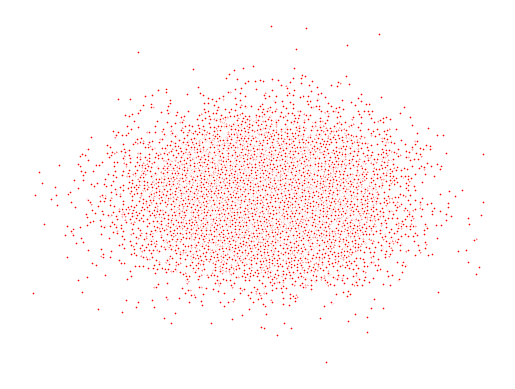

In [11]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_xt_given_x0(dataset, torch.tensor([i]))
    plt.scatter(q_i[:,0], q_i[:,1], color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

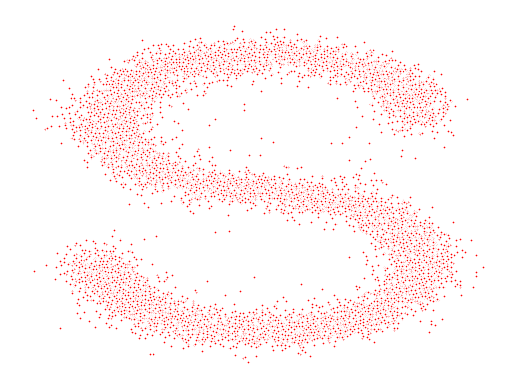

In [12]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach().cpu().numpy()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [13]:
imgs = imgs + reverse

In [14]:
len(imgs)

200

In [15]:
imgs[0].save("./diffusion.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)